## Projet 6 : Catégorisez automatiquement des questions

### Etape 1: Data cleaning et pré-traitement des données textuelles

#### Fonctions utiles

#### Fonction qui convertit un document texte original en un document cleané pour utilisation ultérieure par les algorithmes ML:
- suppression du code HTML (tags + le contenu pour les tags 'code','a','img','del','s' )
- suppression de tous les caractères non alphabétiques sauf les caractères spéciaux '#+-'
- conservation de la racine des mots uniquement (stemming)
- suppression des mots à 0 ou 1 caractère s'ils existent

In [1]:
import re
from nltk.stem import PorterStemmer

def prepare_text(text, stopwords, punkt=None):
    #supprime les tags HTML et certains contenus non représentatifs du langage naturel
    text = clean_html(text)

    # supprime la ponctuation
    if punkt is not None:
        text = text.translate(punkt)
    
    # lower case & tokenization
    text = text.lower().split()
    
    # supprime les caractères non-alphabétiques    
    text = [ re.sub("[^a-zA-Z#+-]", "", word) for word in text ]   
      
    # stemming
    stemmer = PorterStemmer()
    text = [stemmer.stem(w) for w in text if not w in stopwords]   
    
    # suppression des mots à 0 ou 1 caractère
    text = [w for w in text if len(w) > 1]
        
    # retourne un ensemble de mots séparés par des espaces et représentant le texte cleané
    return ' '.join(text)

#### Fonction de cleaning des éléments HTML non représentatifs du langage naturel (ex: code, hyperliens etc..)
cf. tags HTML autorisés par STOVF: https://meta.stackexchange.com/questions/1777/what-html-tags-are-allowed-on-stack-exchange-sites

In [2]:
def clean_html(text):
    # liste des tags dont on veut supprimer le contenu (et pas seulement les tags)
    tags_to_remove = ['code','a','img','del','s']

    bs = BeautifulSoup(text, "html.parser")
    
    tags = bs.find_all(tags_to_remove)
    
    # suppression du contenu pour chaque tag identifié dans le texte
    for tag in tags:
        tag.extract()
        
    return bs.get_text()

#### Fonctions de tracé

In [4]:
# Fonction de tracé d'un barplot pour une Series
def trace_barplot(y, title, kind='bar'):
    if (kind=='bar'):
        plt.xticks(range(len(y)), list(y.index),rotation = 0, fontsize=14)
        plt.bar(range(len(y)),y,width = 0.2, color='red')   
    elif (kind=='barh'):       
        plt.yticks(range(len(y)), list(y.index),rotation = 0, fontsize=14)
        plt.barh(range(len(y)),y,height = 0.2, color='red')
    plt.title(title)

In [5]:
# Fonction de tracé d'un histogramme pour un array/Series
def trace_hist(y,title,xlabel,ylabel, n_bins):
    plt.hist(y, range=(y.min(), y.max()), bins=n_bins,color='yellow',edgecolor='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

---

### Chargement des données StackOverFlow résultat de la requête sql d'extraction

In [6]:
import pandas as pd
%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [7]:
nb_datasets = 10

for i in range(nb_datasets):
    csv_filepath = 'C:\\Formation\\Data scientist\\Projet_6\\datasets\\QueryResults_{}.csv'.format(i)
    stackovf_data_tmp = pd.read_csv(csv_filepath, low_memory=False)
    stackovf_data = pd.concat([stackovf_data, stackovf_data_tmp]) if i > 0 else stackovf_data_tmp

del stackovf_data_tmp

stackovf_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131257 entries, 0 to 47937
Data columns (total 4 columns):
id       131257 non-null int64
Body     131257 non-null object
Title    131256 non-null object
Tags     131257 non-null object
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


In [8]:
stackovf_data.head()

,id,Body,Title,Tags
0,4,<p>I want to use a track-bar to change a form'...,"While applying opacity to a form, should we us...",<c#><winforms><type-conversion><decimal><opacity>
1,6,<p>I have an absolutely positioned <code>div</...,Percentage width child element in absolutely p...,<html><css><css3><internet-explorer-7>
2,9,<p>Given a <code>DateTime</code> representing ...,How do I calculate someone's age in C#?,<c#><.net><datetime>
3,11,<p>Given a specific <code>DateTime</code> valu...,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...
4,13,<p>Is there any standard way for a Web Server ...,Determine a User's Timezone,<javascript><html><browser><timezone><timezone...


In [9]:
np.sum(stackovf_data.isnull())

id       0
Body     0
Title    1
Tags     0
dtype: int64

#### Suppression d'une ligne avec le champ Title à NaN

In [10]:
stackovf_data.drop(stackovf_data[stackovf_data.Title.isnull()].index, axis=0, inplace=True)

### Text Preprocessing

#### Concernant la phase de prétraitement de texte, on travaille sur un exemple dans un 1er temps avant d'itérer sur le dataset

In [11]:
question_example = stackovf_data.Body.iloc[0]

In [12]:
question_example

"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n"

#### 1. Remove HTML

In [13]:
from bs4 import BeautifulSoup

In [14]:
# liste des tags dont on veut supprimer le contenu (et pas seulement les tags)
tags_to_remove = ['code','a','img','del','s']

bs = BeautifulSoup(question_example, "html.parser")
    
tags = bs.find_all(tags_to_remove)
    
# suppression du contenu pour chaque tag identifié dans le texte
for tag in tags:
    tag.extract()
        
question_example = bs.get_text()

In [15]:
question_example

"I want to use a track-bar to change a form's opacity.\nThis is my code:\n\nWhen I build the application, it gives the following error:\n\nCannot implicitly convert type  to .\n\nI tried using  and  but then the control doesn't work. This code worked fine in a past VB.NET project.\n"

#### 2. Convert to lower case & tokenization

In [16]:
question_example = question_example.lower().split()

In [17]:
question_example

['i',
 'want',
 'to',
 'use',
 'a',
 'track-bar',
 'to',
 'change',
 'a',
 "form's",
 'opacity.',
 'this',
 'is',
 'my',
 'code:',
 'when',
 'i',
 'build',
 'the',
 'application,',
 'it',
 'gives',
 'the',
 'following',
 'error:',
 'cannot',
 'implicitly',
 'convert',
 'type',
 'to',
 '.',
 'i',
 'tried',
 'using',
 'and',
 'but',
 'then',
 'the',
 'control',
 "doesn't",
 'work.',
 'this',
 'code',
 'worked',
 'fine',
 'in',
 'a',
 'past',
 'vb.net',
 'project.']

#### 3. Remove non-letters & some punctuations ('#+-')

In [18]:
import re

question_example = [ re.sub("[^a-zA-Z#+-]", "", word) for word in question_example ]   

In [19]:
question_example 

['i',
 'want',
 'to',
 'use',
 'a',
 'track-bar',
 'to',
 'change',
 'a',
 'forms',
 'opacity',
 'this',
 'is',
 'my',
 'code',
 'when',
 'i',
 'build',
 'the',
 'application',
 'it',
 'gives',
 'the',
 'following',
 'error',
 'cannot',
 'implicitly',
 'convert',
 'type',
 'to',
 '',
 'i',
 'tried',
 'using',
 'and',
 'but',
 'then',
 'the',
 'control',
 'doesnt',
 'work',
 'this',
 'code',
 'worked',
 'fine',
 'in',
 'a',
 'past',
 'vbnet',
 'project']

#### 4. Apply Stemming and remove stop words

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arsal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
 
stemmer = PorterStemmer()

stopwords = set(stopwords.words("english")) 

question_example = [stemmer.stem(w) for w in question_example if not w in stopwords]

#### 5. Suppression des mots à 0 ou 1 seul caractère s'ils existent

In [22]:
question_example = [w for w in question_example if len(w) > 1]

In [23]:
question_example

['want',
 'use',
 'track-bar',
 'chang',
 'form',
 'opac',
 'code',
 'build',
 'applic',
 'give',
 'follow',
 'error',
 'cannot',
 'implicitli',
 'convert',
 'type',
 'tri',
 'use',
 'control',
 'doesnt',
 'work',
 'code',
 'work',
 'fine',
 'past',
 'vbnet',
 'project']

#### 6. Join the words into one string with spaces

In [24]:
' '.join( question_example )

'want use track-bar chang form opac code build applic give follow error cannot implicitli convert type tri use control doesnt work code work fine past vbnet project'

#### Texte d'origine de la question STOVF

In [25]:
stackovf_data.Body.iloc[0]

"<p>I want to use a track-bar to change a form's opacity.</p>\n\n<p>This is my code:</p>\n\n<pre><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n\n<p>When I build the application, it gives the following error:</p>\n\n<blockquote>\n  <p>Cannot implicitly convert type <code>'decimal'</code> to <code>'double'</code>.</p>\n</blockquote>\n\n<p>I tried using <code>trans</code> and <code>double</code> but then the control doesn't work. This code worked fine in a past VB.NET project.</p>\n"

#### Appel de la fonction <i>prepare_text</i> qui reprend les 6 opérations de cleaning du texte 

In [26]:
prepare_text(stackovf_data.Body.iloc[0], stopwords)

'want use track-bar chang form opac code build applic give follow error cannot implicitli convert type tri use control doesnt work code work fine past vbnet project'

### Cleaning des posts STOVF (Body + Title)

In [27]:
stackovf_data = stackovf_data.assign(
    Body_cleaned = stackovf_data.Body.apply(lambda x: prepare_text(x, stopwords)),
    Title_cleaned = stackovf_data.Title.apply(lambda x: prepare_text(x, stopwords))
)

In [28]:
stackovf_data[['Body','Body_cleaned','Title','Title_cleaned']].head()

,Body,Body_cleaned,Title,Title_cleaned
0,<p>I want to use a track-bar to change a form'...,want use track-bar chang form opac code build ...,"While applying opacity to a form, should we us...",appli opac form use decim doubl valu
1,<p>I have an absolutely positioned <code>div</...,absolut posit contain sever children one rel p...,Percentage width child element in absolutely p...,percentag width child element absolut posit pa...
2,<p>Given a <code>DateTime</code> representing ...,given repres person birthday calcul age year,How do I calculate someone's age in C#?,calcul someon age c#
3,<p>Given a specific <code>DateTime</code> valu...,given specif valu display rel time like hour a...,Calculate relative time in C#,calcul rel time c#
4,<p>Is there any standard way for a Web Server ...,standard way web server abl determin user time...,Determine a User's Timezone,determin user timezon


In [29]:
print('Question d\'origine avant cleaning:\n\n', stackovf_data.Body.iloc[1])
print('----------------------------------------------------------\n')
print('Question après cleaning:\n\n', stackovf_data.Body_cleaned.iloc[1])

Question d'origine avant cleaning:

 <p>I have an absolutely positioned <code>div</code> containing several children, one of which is a relatively positioned <code>div</code>. When I use a <strong>percentage-based width</strong> on the child <code>div</code>, it collapses to '0' width on <a href="http://en.wikipedia.org/wiki/Internet_Explorer_7" rel="noreferrer">Internet&nbsp;Explorer&nbsp;7</a>, but not on Firefox or Safari.</p>

<p>If I use <strong>pixel width</strong>, it works. If the parent is relatively positioned, the percentage width on the child works.</p>

<ol>
<li>Is there something I'm missing here?</li>
<li>Is there an easy fix for this besides the <em>pixel-based width</em> on the
child?</li>
<li>Is there an area of the CSS specification that covers this?</li>
</ol>

----------------------------------------------------------

Question après cleaning:

 absolut posit contain sever children one rel posit use percentage-bas width child collaps width firefox safari use pixel 

In [318]:
print('Titre d\'origine avant cleaning:\n\n', stackovf_data.Title.iloc[1])
print('----------------------------------------------------------\n')
print('Titre après cleaning:\n\n', stackovf_data.Title_cleaned.iloc[1])

Titre d'origine avant cleaning:

 How do I calculate someone's age in C#?
----------------------------------------------------------

Titre après cleaning:

 calcul someon age c#


---

### Extraction des features avec un modèle 'Bags of words' 

In [495]:
from sklearn import model_selection

X = stackovf_data[['Body_cleaned','Title_cleaned']][:15000] 
y = stackovf_data.Tags[:15000]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33)

### CountVectorizer

In [496]:
from sklearn.feature_extraction.text import CountVectorizer

# on considère les unigrams et bigrams
count_vect = CountVectorizer(ngram_range=(1,2))

# pour des raisons de capacité mémoire, nous nous limiterons à 10000 documents
features = count_vect.fit_transform(X_train.Body_cleaned).toarray()

In [497]:
vocabulary = count_vect.get_feature_names()
print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:288830


#### Réduisons la taille du vocabulaire à l'aide des paramètres min_df et max_df 

In [498]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_df=0.5)

features = count_vect.fit_transform(X_train.Body_cleaned).toarray()

vocabulary = count_vect.get_feature_names()
print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:5831


#### Visualisation de la fréquence des termes par ordre croissant dans le corpus

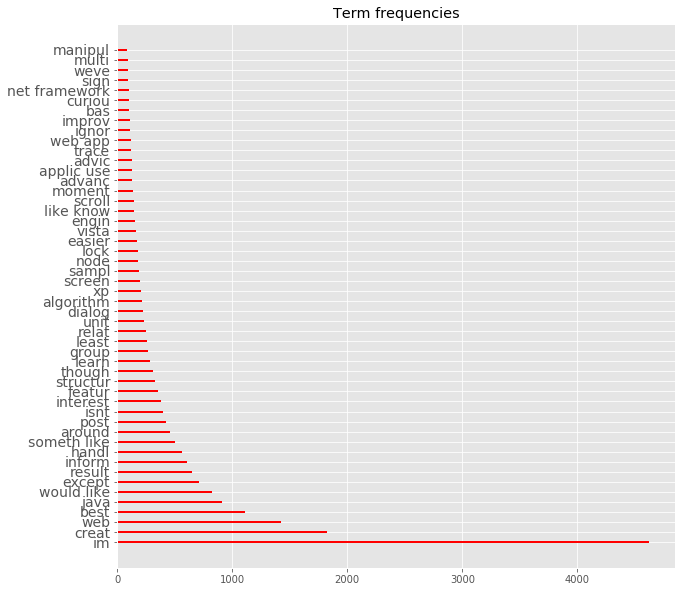

In [499]:
term_frequencies = pd.Series(np.sum(features, axis=0), index=vocabulary)

plt.figure(figsize=(10,10))
# on visualise un terme sur 'step' pour avoir une vue d'ensemble
step = 20
trace_barplot(term_frequencies.sort_values(ascending=False)[::step].head(50), 'Term frequencies', kind='barh')

In [500]:
vocabulary[0:15]

['abc',
 'abil',
 'abl',
 'abl access',
 'abl chang',
 'abl creat',
 'abl find',
 'abl get',
 'abl handl',
 'abl pass',
 'abl read',
 'abl run',
 'abl see',
 'abl use',
 'abort']

#### Calcul du nbre de termes ayant une fréquence < 20 ou > 1000 dans le corpus

In [501]:
print('Nbre de termes avec freq. < 20: %i' % len(term_frequencies[term_frequencies < 20]))
print('Nbre de termes avec freq. > 2000: %i' % len(term_frequencies[term_frequencies > 2000]))

Nbre de termes avec freq. < 20: 2683
Nbre de termes avec freq. > 2000: 19


#### On crée un dataframe pour explorer les données plus facilement

In [502]:
bags_of_words = pd.DataFrame(features, columns=vocabulary)
bags_of_words.head()

,abc,abil,abl,abl access,abl chang,abl creat,abl find,abl get,abl handl,abl pass,...,young,your,your use,youv,yui,zend,zero,zip,zip file,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Calcul pour chaque terme du nombre de documents dans lesquels il est présent (soit df = document frequency)

In [503]:
bags_of_words_nonzeros = []
for column in bags_of_words.columns:  
    bags_of_words_nonzeros.append(bags_of_words[column].nonzero()[0].shape[0])

In [504]:
term_df = pd.Series(bags_of_words_nonzeros, index=bags_of_words.columns)

#### Calcul du nbre de termes ayant un df (nbre de docs) < 20 (= min_df) ou > 2000 (= max_df)

In [505]:
print('Nbre de termes avec df < 20: %i' % len(term_df[term_df < 20]))
print('Nbre de termes avec df > 1500: %i' % len(term_df[term_df > 1500]))

Nbre de termes avec df < 20: 2996
Nbre de termes avec df > 1500: 16


#### On visualise les termes les plus fréquents et donc les moins informatifs

In [506]:
term_df[term_df > 1500].sort_values(ascending=False)

like      3191
im        3024
way       2831
would     2710
work      2399
get       2331
want      2174
code      2168
need      2126
one       2086
know      1862
tri       1757
file      1711
look      1616
ive       1565
applic    1548
dtype: int64

#### On réajuste les paramètres de l'instance CountVectorizer avec min_df = 20 et max_df = 15 %

In [507]:
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_df=0.15)

features = count_vect.fit_transform(X_train.Body_cleaned).toarray()

vocabulary = count_vect.get_feature_names()

print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:2819


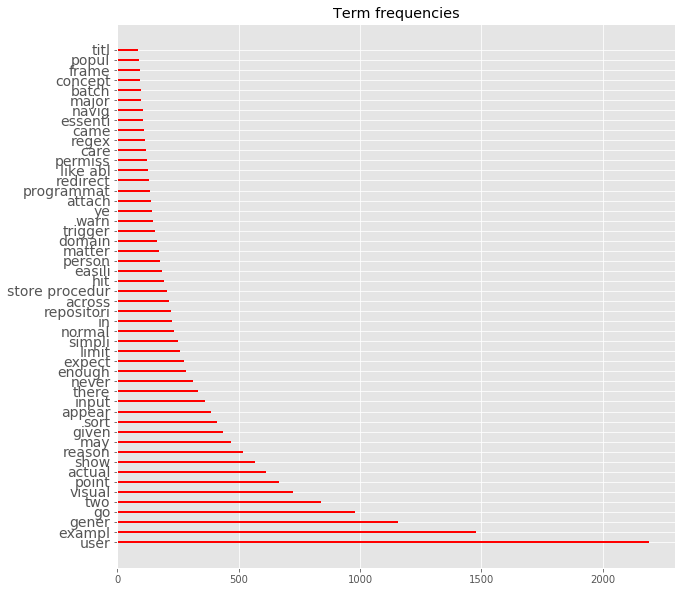

In [508]:
term_frequencies = pd.Series(np.sum(features, axis=0), index=vocabulary)

plt.figure(figsize=(10,10))
step = 20
trace_barplot(term_frequencies.sort_values(ascending=False)[::step].head(50), 'Term frequencies', kind='barh')

In [509]:
bags_of_words = pd.DataFrame(features, columns=vocabulary)
bags_of_words.head()

,abil,abl,abl creat,abl find,abl get,abl run,abl use,absolut,abstract,accept,...,year,year ago,yet,yield,youd,your,youv,zero,zip,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TfidfVectorizer

#### On reprend les mêmes paramètres que pour le CountVectorizer

In [510]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_df=0.15)

features = tfidf_vect.fit_transform(X_train.Body_cleaned).toarray()

In [511]:
vocabulary = tfidf_vect.get_feature_names()

print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:2819


#### Tracé des termes les plus significatifs en terme tf-idf

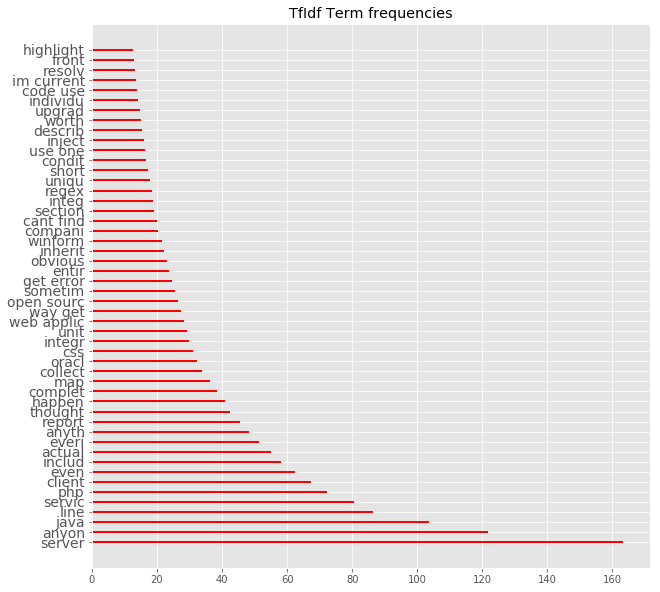

In [512]:
tfidf_freq = pd.Series(np.sum(features, axis=0), index=vocabulary)

plt.figure(figsize=(10,10))
step = 20
trace_barplot(tfidf_freq.sort_values(ascending=False)[::step].head(50), 'TfIdf Term frequencies', kind='barh')

#### Visualisation des termes les plus significatifs en terme idf (inverse document frequency)

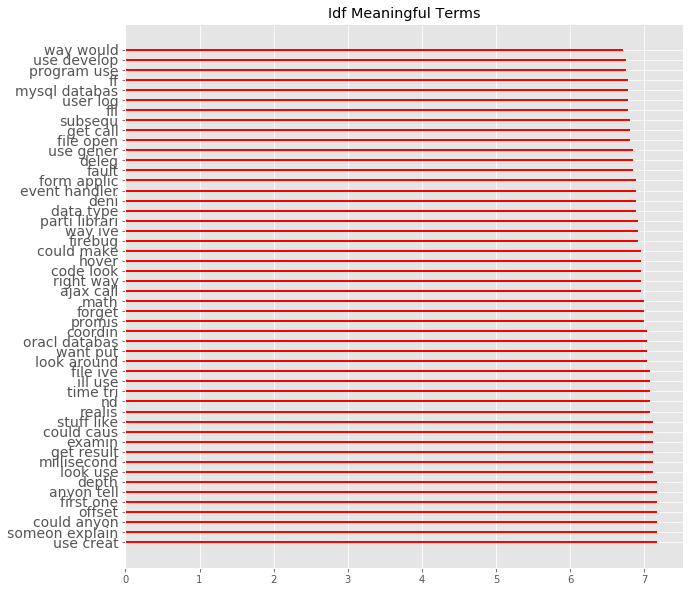

In [513]:
idf_meaningful_term = pd.Series(tfidf_vect.idf_, index=vocabulary)

plt.figure(figsize=(10,10))
step=20
trace_barplot(idf_meaningful_term.sort_values(ascending=False)[::step].head(50), 'Idf Meaningful Terms', kind='barh')

In [514]:
# on visualise le top 10 des termes les moins significatifs
idf_meaningful_term.sort_values(ascending=True)[:10]

run        3.018741
make       3.020240
creat      3.020991
problem    3.044539
someth     3.046077
time       3.053805
set        3.078944
anyon      3.078944
user       3.078944
seem       3.080537
dtype: float64

#### On trace la distribution des valeurs tf-idf (histogramme)

(0, 80)

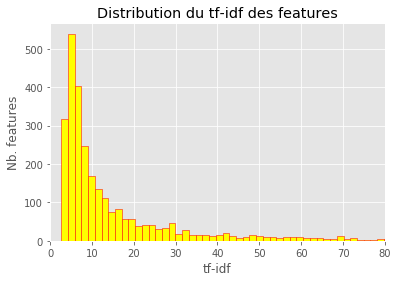

In [515]:
trace_hist(tfidf_freq,'Distribution du tf-idf des features','tf-idf','Nb. features',100)
plt.xlim(0,80)

In [516]:
# Valeur du quantile idf pour 50 % des termes les moins significatifs
tfidf_quantile = tfidf_freq.quantile([0.5])
tfidf_quantile

0.5    8.35324
dtype: float64

In [517]:
len(tfidf_freq[tfidf_freq < 8.4])

1412

#### On relance l'analyseur TfidfVectorizer en tenant compte des stopwords supplémentaires constitués des termes les moins significatifs

In [518]:
# termes dont l'idf est < 8.35 = valeur du quantile à 50 % (cf. ci-dessus)
stop_words_2 = list(tfidf_freq[tfidf_freq < tfidf_quantile.iloc[0]].index)

tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=20, max_df=0.15, stop_words=stop_words_2)

features = tfidf_vect.fit_transform(X_train.Body_cleaned).toarray()
vocabulary = tfidf_vect.get_feature_names()

print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:2200


#### Vérification de la prise en compte des stop words en paramètre

In [555]:
#tfidf_vect.stop_words_

#### Tracé à nouveau des termes les plus significatifs en terme tf-idf

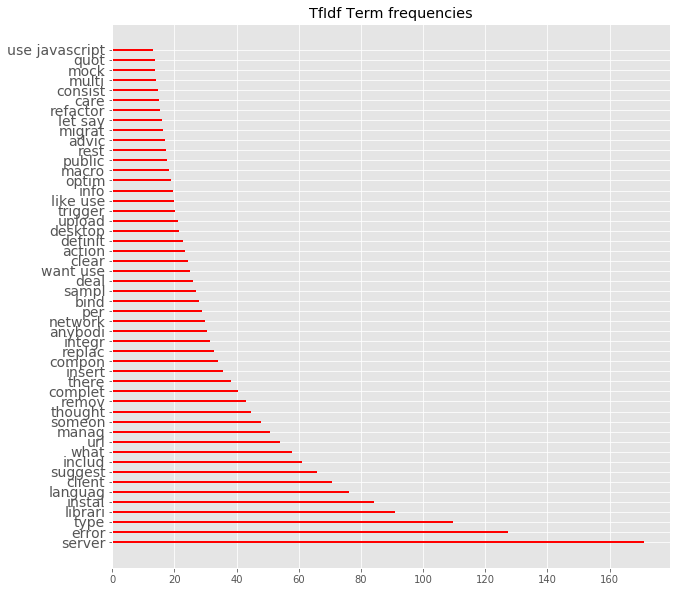

In [519]:
tfidf_freq = pd.Series(np.sum(features, axis=0), index=vocabulary)

plt.figure(figsize=(10,10))
step = 20
trace_barplot(tfidf_freq.sort_values(ascending=False)[::step].head(50), 'TfIdf Term frequencies', kind='barh')

### Exploration des tags

In [520]:
y_train.head()

3026                          <database><algorithm><diff>
2851    <sql-server><sql-server-2005><configuration><s...
301             <c++><configuration><netbeans><wxwidgets>
2480                     <c><linux><debugging><exception>
1123                           <vbscript><error-handling>
Name: Tags, dtype: object

#### Ajout d'une colonne Tags_cleaned contenant les tags sous forme de chaine de caractères séparés par un espace

In [521]:
stackovf_data = stackovf_data.assign(
    Tags_cleaned = stackovf_data.Tags.apply(lambda x: ' '.join(x.lstrip('<').rstrip('>').split('><')))
)

In [522]:
stackovf_data[['Tags','Tags_cleaned']].head()

,Tags,Tags_cleaned
1,<html><css><css3><internet-explorer-7>,html css css3 internet-explorer-7
2,<c#><.net><datetime>,c# .net datetime
3,<c#><datetime><time><datediff><relative-time-s...,c# datetime time datediff relative-time-span
4,<javascript><html><browser><timezone><timezone...,javascript html browser timezone timezoneoffset
5,<.net><math>,.net math


#### Idem sur le jeu d'entrainement

In [523]:
y_train = y_train.apply(lambda x: ' '.join(x.lstrip('<').rstrip('>').split('><')))

In [524]:
y_test = y_test.apply(lambda x: ' '.join(x.lstrip('<').rstrip('>').split('><')))

#### CountVectorizer

In [525]:
count_vect = CountVectorizer(ngram_range=(1,1), tokenizer=str.split)

features_tags = count_vect.fit_transform(y_train).toarray()
vocab_tags = count_vect.get_feature_names()

In [526]:
print('Nbre total de tags distincts: %i' % len(vocab_tags))

Nbre total de tags distincts: 4006


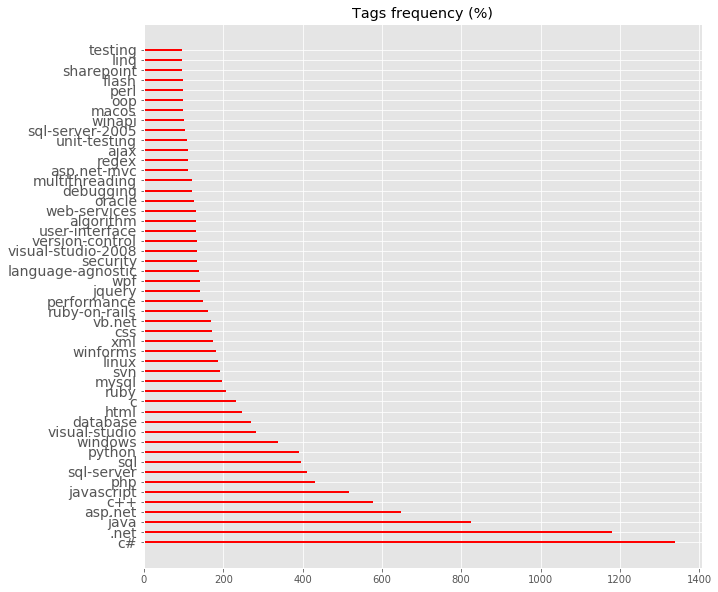

In [527]:
freq_tags = pd.Series(np.sum(features_tags,axis=0), index=vocab_tags)

plt.figure(figsize=(10,10))
trace_barplot(freq_tags.sort_values(ascending=False).head(50), 'Tags frequency (%)', kind='barh')

#### Tracé de la répartition du nombre de tags vs nbre de documents

(0, 100)

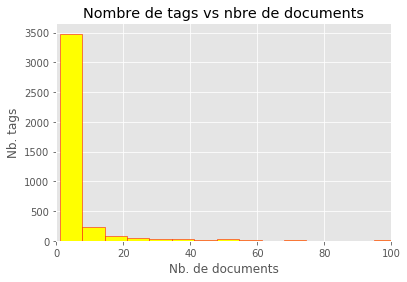

In [528]:
trace_hist(freq_tags,'Nombre de tags vs nbre de documents','Nb. de documents','Nb. tags', 200)
plt.xlim(0,100)

In [529]:
print('Nbre de tags associés à moins de 20 documents: %i' % len(freq_tags[freq_tags < 20]))

Nbre de tags associés à moins de 20 documents: 3760


In [530]:
print('machine-learning' in vocab_tags)
print('Nb posts sur machine-learning: %i' % freq_tags['machine-learning'])

True
Nb posts sur machine-learning: 2


#### Tags cleaning: on supprime les tags ayant un df (document frequency) < 20
Note: chaque tag n'apparait qu'une fois pour un document, ce qui est équivalent à une fréquence sur le corpus (df)

In [531]:
tags_to_remove = freq_tags[freq_tags < 20]
print('Nbre de tags à supprimer: %i' % len(tags_to_remove))

# Tags cleaning
stackovf_data = stackovf_data.assign(
    Tags_cleaned_2 = stackovf_data.Tags_cleaned.apply(lambda x: ' '.join(set(x.split()).difference(set(tags_to_remove.index))))
)

Nbre de tags à supprimer: 3760


In [532]:
stackovf_data[['Tags','Tags_cleaned','Tags_cleaned_2']].head()

,Tags,Tags_cleaned,Tags_cleaned_2
1,<html><css><css3><internet-explorer-7>,html css css3 internet-explorer-7,css html
2,<c#><.net><datetime>,c# .net datetime,.net datetime c#
3,<c#><datetime><time><datediff><relative-time-s...,c# datetime time datediff relative-time-span,relative-time-span datetime c# time
4,<javascript><html><browser><timezone><timezone...,javascript html browser timezone timezoneoffset,html javascript browser
5,<.net><math>,.net math,.net math


#### Idem sur les données d'entrainement et de test

In [533]:
y_train = y_train.apply(lambda x: ' '.join(set(x.split()).difference(set(tags_to_remove.index))))

In [534]:
y_test = y_test.apply(lambda x: ' '.join(set(x.split()).difference(set(tags_to_remove.index))))

#### TfidfVectorizer

In [535]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), tokenizer=str.split)

tfidf_features_tags = tfidf_vect.fit_transform(y_train).toarray()
tfidf_vocab_tags = tfidf_vect.get_feature_names()

#### Tracé des tags les plus significatifs en terme tf-idf

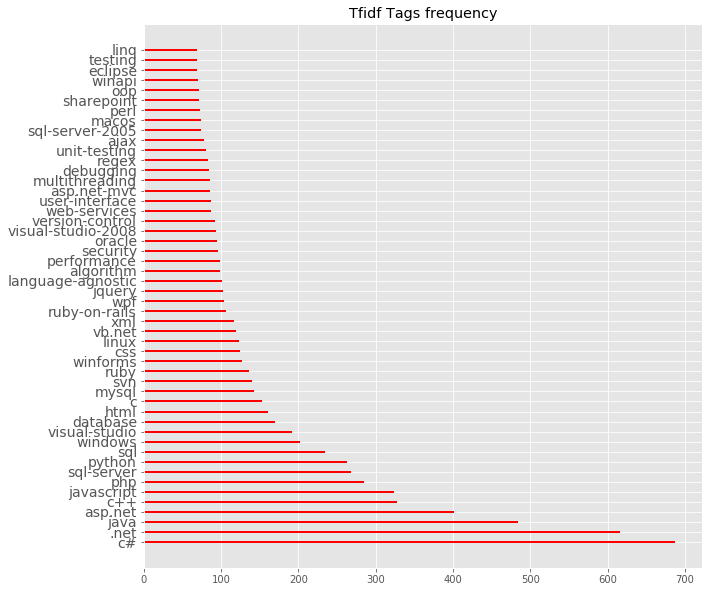

In [536]:
tfidf_freq_tags = pd.Series(np.sum(tfidf_features_tags,axis=0), index=tfidf_vocab_tags)

plt.figure(figsize=(10,10))
trace_barplot(tfidf_freq_tags.sort_values(ascending=False).head(50), 'Tfidf Tags frequency', kind='barh')

In [537]:
# tags les - significatifs car les + courants
tfidf_freq_tags.tail(5)

wpf      103.097712
xaml      20.754508
xml      116.731940
xpath     14.558262
xslt      28.721103
dtype: float64

#### Calcul du nombre de tags pour chaque document

In [538]:
stackovf_data = stackovf_data.assign(
    Nb_tags = stackovf_data.Tags_cleaned_2.apply(lambda x:len(x.split()))
)

print('Nbre maximum de tags: %i' % stackovf_data.Nb_tags.max())

Nbre maximum de tags: 5


In [539]:
stackovf_data.Nb_tags.value_counts()

2    36139
1    25992
3    21782
4     7578
5     1272
0      141
Name: Nb_tags, dtype: int64

#### On supprime les données qui ont 0 tag

In [540]:
stackovf_data.drop(stackovf_data[stackovf_data.Nb_tags == 0].index, axis=0, inplace=True)

#### idem sur les données d'entrainement et de test (X et y pour synchroniser sur les indexs)

In [541]:
X_train.drop(y_train[y_train.eq('')].index, axis=0, inplace=True)
X_test.drop(y_test[y_test.eq('')].index, axis=0, inplace=True)


C:\Developpement\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Developpement\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [542]:
y_train.drop(y_train[y_train.eq('')].index, axis=0, inplace=True)
y_test.drop(y_test[y_test.eq('')].index, axis=0, inplace=True)

### Exploration des titres des posts STOVF

In [543]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=20, max_df=0.15)

features = tfidf_vect.fit_transform(X_train.Title_cleaned).toarray()
vocabulary = tfidf_vect.get_feature_names()

print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:540


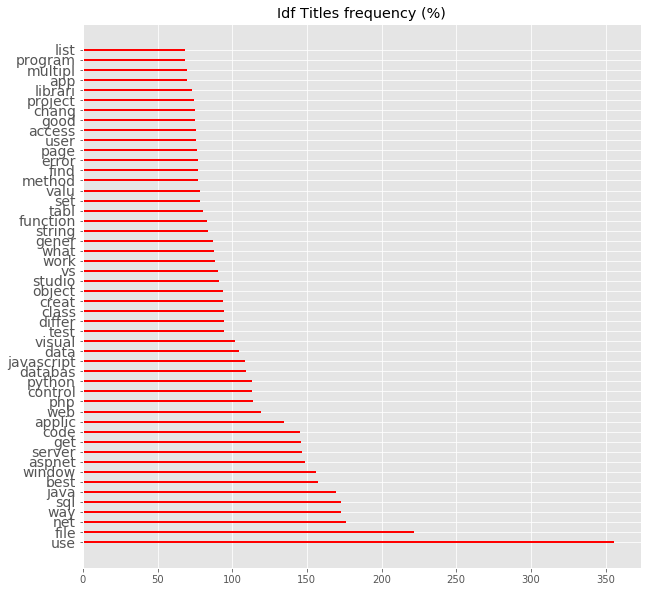

In [544]:
freq_titles = pd.Series(np.sum(features, axis=0), index=vocabulary)

plt.figure(figsize=(10,10))
trace_barplot(freq_titles.sort_values(ascending=False).head(50), 'Idf Titles frequency (%)', kind='barh')

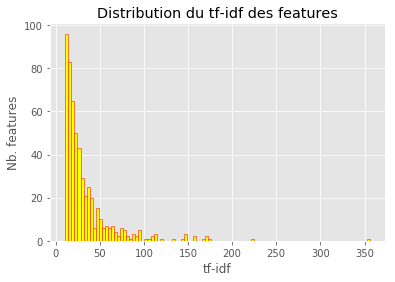

In [545]:
trace_hist(freq_titles,'Distribution du tf-idf des features','tf-idf','Nb. features',100)

In [546]:
tfidf_quantile = freq_titles.quantile([0.5])
tfidf_quantile

0.5    22.832008
dtype: float64

In [547]:
# termes dont l'idf est < 4.5 = valeur du quantile à 10 % (cf. ci-dessus)
stop_words_title = list(freq_titles[freq_titles < tfidf_quantile.iloc[0]].index)

tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=20, max_df=0.15, stop_words=stop_words_title)

features = tfidf_vect.fit_transform(X_train.Title_cleaned).toarray()
vocabulary = tfidf_vect.get_feature_names()

print('Taille du vocabulaire:%i' % len(vocabulary))

Taille du vocabulaire:270


### Sauvegarde du dataset d'entrainement et de test

In [548]:
trainset = pd.concat([X_train, y_train], axis=1)
trainset.to_pickle('C:\\Formation\\Data scientist\\Projet_6\\datasets\\trainset_4ml.pkl', compression='infer')

In [549]:
testset = pd.concat([X_test, y_test], axis=1)
testset.to_pickle('C:\\Formation\\Data scientist\\Projet_6\\datasets\\testset_4ml.pkl', compression='infer')

#### Ainsi que le dataset d'origine  

In [550]:
stackovf_data.to_pickle('C:\\Formation\\Data scientist\\Projet_6\\datasets\\stovfset_4ml.pkl', compression='infer')

---